In [1]:
import drama as drm
import numpy as np
import matplotlib.pylab as plt
from matplotlib import gridspec
from sklearn.metrics import roc_auc_score

import os
import glob
import h5py
import scipy.io as sio

%matplotlib inline

In [12]:
fils = sorted(glob.glob('../data/*.mat'), key=os.path.getsize)[:5]
n_files = len(fils)
file_names = [i.split('/')[-1][:-4] for i in fils]
print file_names

['lympho', 'breastw', 'wine', 'vertebral', 'glass']


In [13]:
# def get_novelties(X_train,X,drt_name,metrics,clustering=None,n_slpit=2,z_dim=2,space='both'):

#     dim_rs ={'AE':'AE','VAE':'VAE','PCA':PCA(n_components=z_dim),'NMF':NMF(n_components=z_dim), 
#              'FastICA':FastICA(n_components=z_dim, max_iter=1000)}
             
#     if drt_name not in dim_rs.keys():   		
#         print 'Selected dimensionality reduction name is not recognized \n'+\
#               'Please chose one from:',dim_rs.keys()
#         return
        
#     outliers = {'real':None,'latent':None}

#     if clustering is None:
#         agg = AgglomerativeClustering()
#         clustering = agg.fit_predict
        
#     splitter = Splitter(X_train, reducer = dim_rs[drt_name], clustering = clustering, z_dim=z_dim)

#     # Splitting
#     splitter.split(n_slpit,verbose=0,training_epochs=20)

#     # outlier extraction for all of requeste metrics
#     if space=='real':
#         outliers['real'] = outliers_real(X,splitter,metrics)
#     elif space=='latent':
#         outliers['latent'] = outliers_latent(splitter,metrics)
#     else:
#         outliers['real'] = outliers_real(X,splitter,metrics)
#         outliers['latent'] = outliers_latent(splitter,metrics)
        
#     return outliers

In [14]:
frac = 0.5

drama_all = []
lof_all = np.zeros((n_files,3))
ifr_all = np.zeros((n_files,3))

for i in range(len(fils)):
    print file_names[i]
    
    try:
        data = sio.loadmat(fils[i])
        X = data['X'].astype(float)
        y = data['y'].astype(float)

    except:
        data = h5py.File(fils[i])
        X = np.array(data['X']).T.astype(float)
        y = np.array(data['y']).T.astype(float)
              
    i_ind = np.argwhere((y == 0))[:,0]
    o_ind = np.argwhere((y != 0))[:,0]
    
    i_train,i_test = drm.random_choice(i_ind,frac)
    
    train_idx = i_train
    test_idx = np.concatenate([i_test,o_ind])
                                                
    X_train = X[train_idx]   
    y_train = y[train_idx]
                                                
    X_test = X[test_idx]
    y_test = y[test_idx]
                     
    res = drm.novelty_finder_all(X_train,X_test,n_slpit=4)
    arr,drts,metrs = drm.result_array(res,y_test,'real')
    drama_all.append(arr)
    
    df = drm.sk_check(X,X,y,[1])
    for j,scr in enumerate(['AUC','MCC','RWS']):
        lof_all[i,j] = df[scr][0]
        ifr_all[i,j] = df[scr][1]
    
drama_all = np.array(drama_all)

lympho


/home/gf/packages/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


breastw
wine
vertebral
glass


/home/gf/packages/anaconda2/lib/python2.7/site-packages/scipy/spatial/distance.py:810: RuntimeWarning: invalid value encountered in double_scalars
  return abs(u - v).sum() / abs(u + v).sum()
/home/gf/packages/anaconda2/lib/python2.7/site-packages/scipy/spatial/distance.py:810: RuntimeWarning: divide by zero encountered in double_scalars
  return abs(u - v).sum() / abs(u + v).sum()


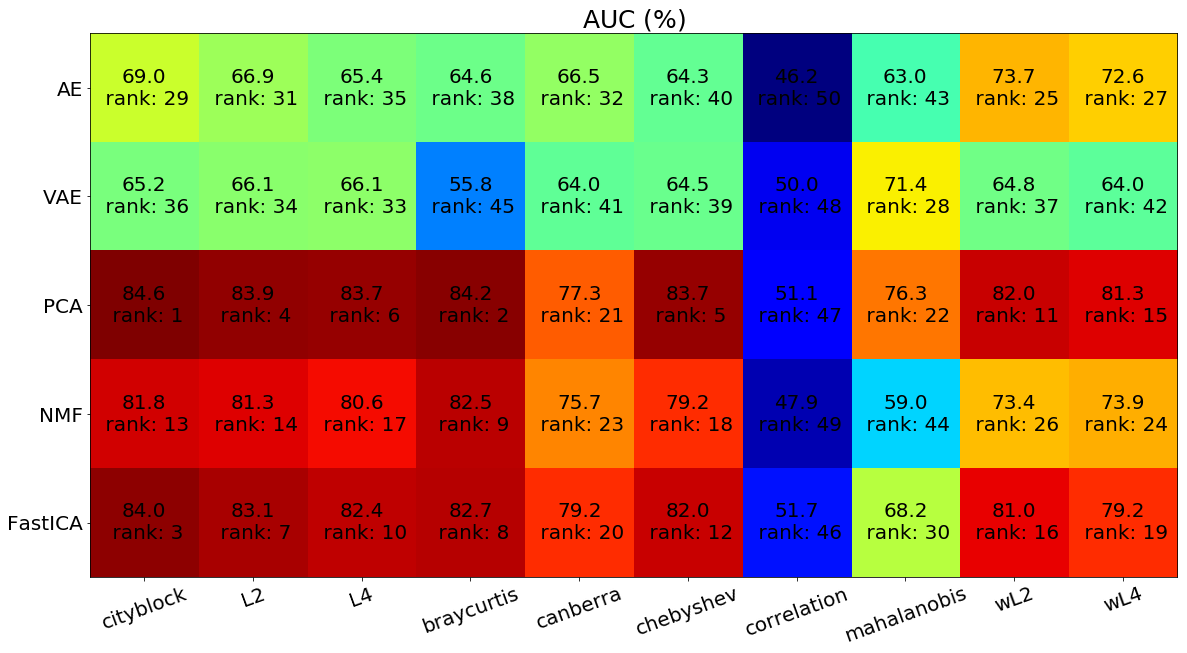

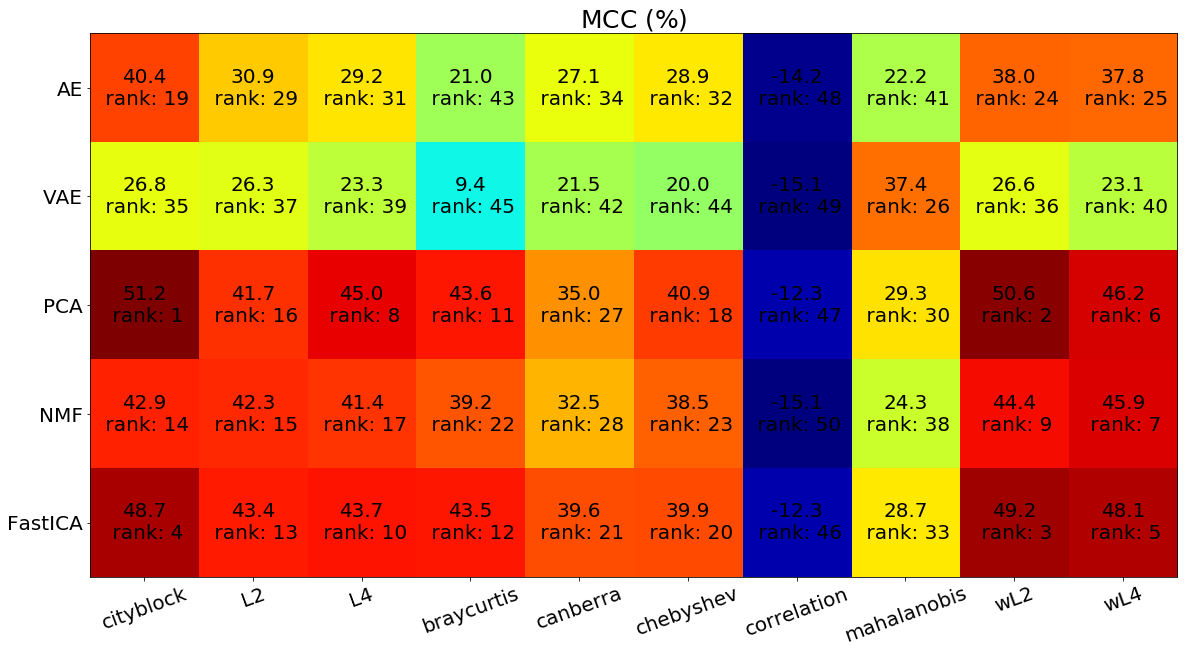

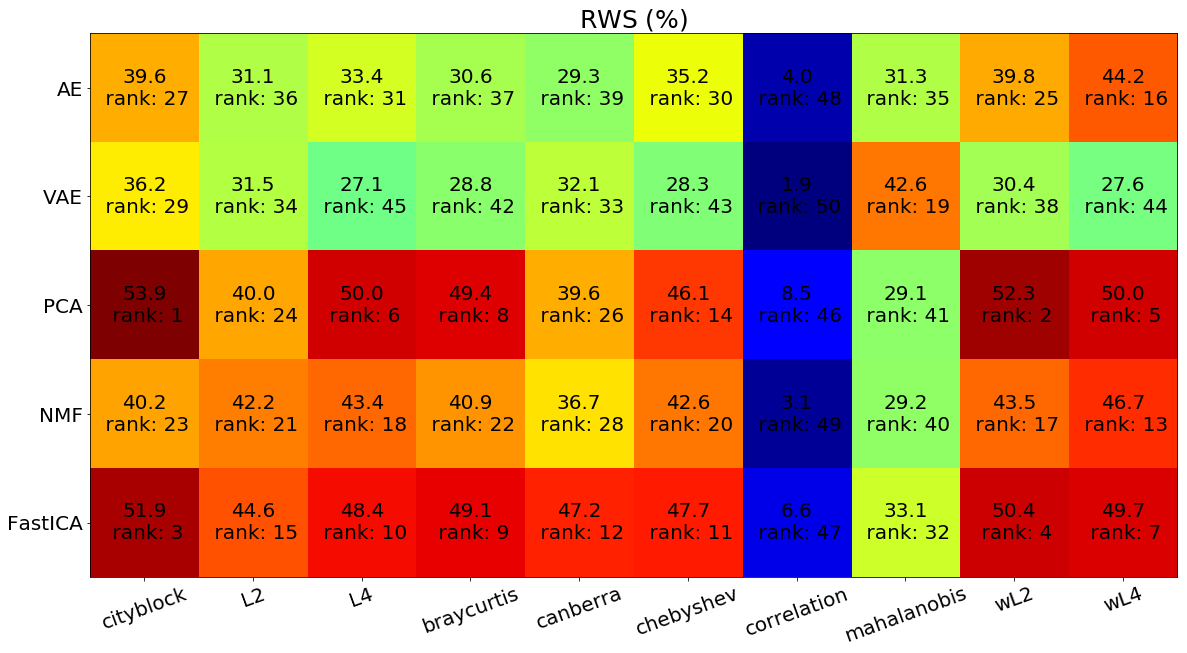

In [17]:
drm.plot_table(np.mean(drama_all,axis=0),drts,metrs)

Text(0,-30,u'** Colors depend on AUC.')

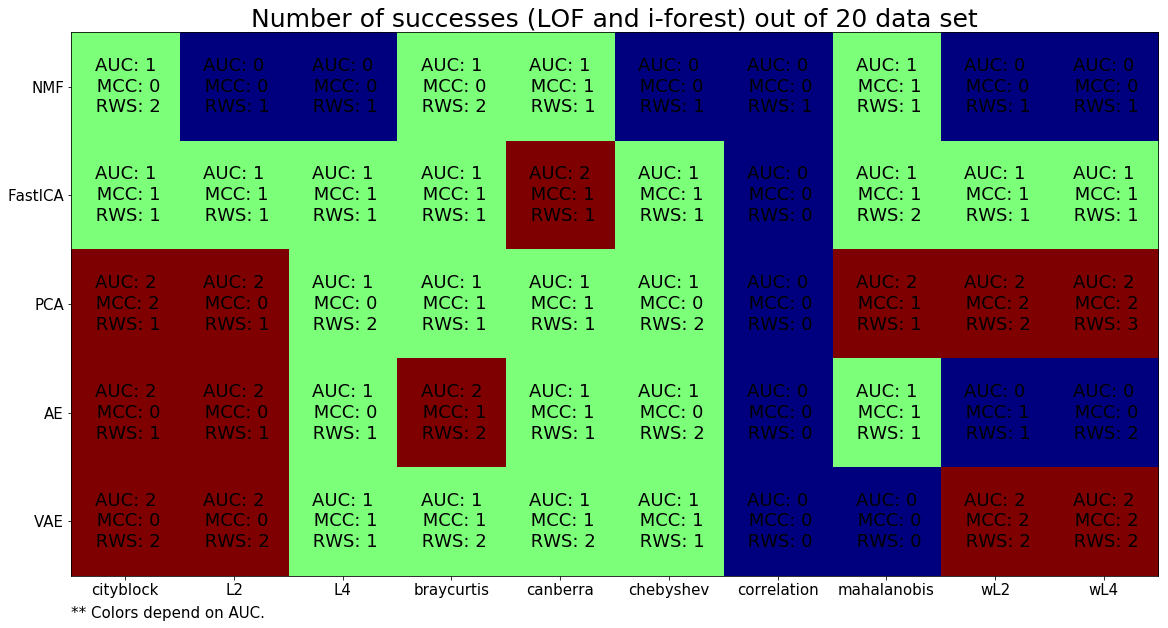

In [18]:
def compare(drama_all,lof_all,ifr_all):
    auc = np.sum((drama_all[:, :, :, 0].T>lof_all[:, 0]) & (drama_all[:, :, :, 0].T>ifr_all[:, 0]),axis=-1).T
    mcc = np.sum((drama_all[:, :, :, 1].T>lof_all[:, 1]) & (drama_all[:, :, :, 1].T>ifr_all[:, 1]),axis=-1).T
    rws = np.sum((drama_all[:, :, :, 2].T>lof_all[:, 2]) & (drama_all[:, :, :, 2].T>ifr_all[:, 2]),axis=-1).T

    fig = plt.figure(figsize=(20,10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect('auto')
    res = ax.imshow(auc, cmap=plt.cm.jet,interpolation='nearest')

    width, height = auc.shape

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate('AUC: {:d}\n MCC: {:d}\n RWS: {:d}'.format(auc[x][y],mcc[x][y],rws[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=18);

    plt.xticks(range(10),['cityblock','L2','L4','braycurtis',
                             'canberra','chebyshev','correlation','mahalanobis','wL2','wL4'],fontsize=15)
    plt.yticks(range(5), ['NMF','FastICA','PCA','AE','VAE'],fontsize=15)

    plt.title('Number of successes (LOF and i-forest) out of 20 data set',fontsize=25)
    plt.annotate('** Colors depend on AUC.', (0,0), (0, -30), xycoords='axes fraction',
                 textcoords='offset points', va='top',fontsize=15)

    # plt.savefig('AND_success.jpg',dpi=150,bbox_inches='tight')